In [1]:
# Correção temporária para compatibilidade entre versões do pandas
import pandas.core.dtypes.common as pdc
from pandas.api.types import is_datetime64_any_dtype, is_timedelta64_dtype

# Função ausente no Pandas — recriada manualmente
pdc.is_datetime_or_timedelta_dtype = (
    lambda arr: is_datetime64_any_dtype(arr) or is_timedelta64_dtype(arr)
)

# 1 - Geração da base e variáveis de controle

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Garantir reprodutibilidade
np.random.seed(42)

# Definindo a série temporal: 36 meses a partir de Jan/2022
periodos = 36
datas = pd.date_range(start='2022-01-01', periods=periodos, freq='MS')
t = np.arange(periodos)  # Vetor de tempo (0 a 35)

# Componentes do Y: tendência, sazonalidade e ruído
tendencia = 50 + 0.5 * t
sazonalidade = 10 * np.sin(2 * np.pi * t / 12)
ruido = np.random.normal(scale=2, size=periodos)

# Choque (impacto causal a partir do mês 24)
inicio_choque = 23  # índice do mês 24 (zero-based)
choque = np.zeros(periodos)
choque[inicio_choque:] = 30  # Adiciona 30 unidades após o choque

# Série observada (Y): soma dos componentes + choque
Y = tendencia + sazonalidade + ruido + choque

# Criação do DataFrame principal
df = pd.DataFrame({
    'date': datas,
    'Y': Y,
    'shock': choque > 0  # True/False indicando período pós-intervenção
})

# Geração de 10 variáveis de controle sintéticas (X1 a X10)
for i in range(1, 11):
    intercepto = 50 + np.random.normal(scale=5)
    inclinacao = 0.5 + np.random.normal(scale=0.05)
    fase = np.random.uniform(0, 2 * np.pi)
    ruido_i = np.random.normal(scale=2, size=periodos)

    df[f'X{i}'] = (
        intercepto +
        inclinacao * t +
        10 * np.sin(2 * np.pi * t / 12 + fase) +
        ruido_i
    )

In [3]:
df.head()

,date,Y,shock,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,2022-01-01,50.993428,False,48.588653,67.473352,64.080306,39.150618,47.066542,50.293696,47.011890,41.929331,49.252999,36.920765
1,2022-02-01,55.223471,False,45.918295,62.664476,68.041871,42.751803,41.553612,53.078514,46.450669,46.346653,55.862958,46.641384
2,2022-03-01,60.955631,False,40.093766,58.941038,65.256656,42.040701,44.054034,52.378064,49.211403,52.481792,62.341553,48.948215
3,2022-04-01,64.546060,False,39.511376,55.061469,60.887531,50.195536,43.479791,58.928730,52.142153,58.138402,62.770832,57.278792
4,2022-05-01,60.191947,False,47.356312,53.390829,51.790309,56.526511,48.983883,60.902135,53.522360,57.849333,60.971631,56.245127


# 2 - Visualizacao da serie

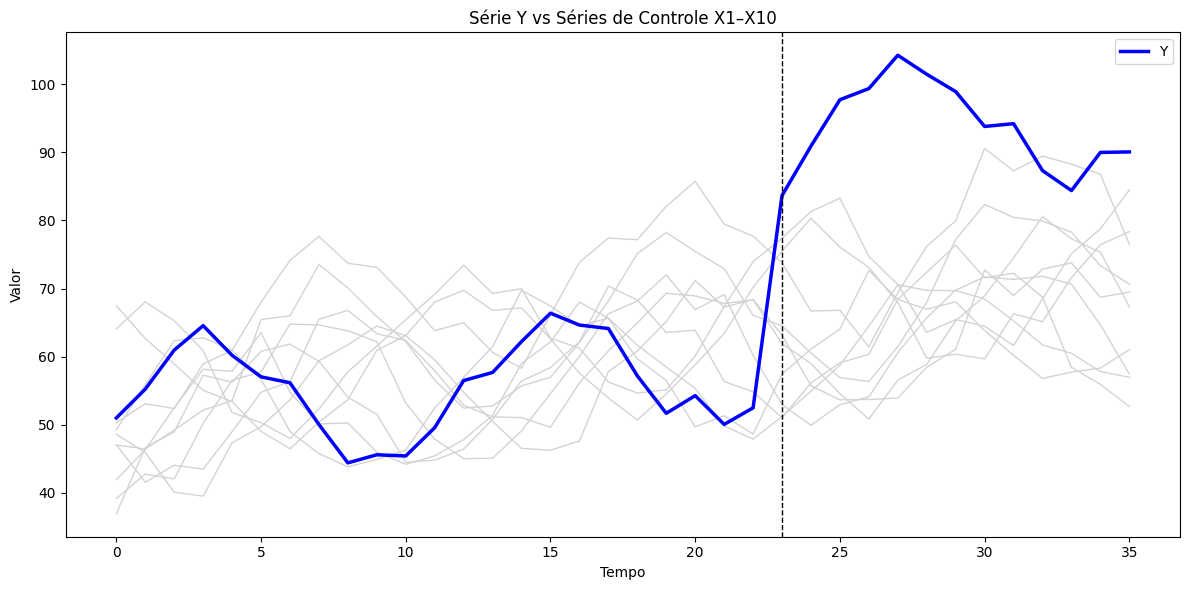

In [4]:
plt.figure(figsize=(12, 6))

# Plot das séries de controle em cinza claro
for i in range(1, 11):
    plt.plot(df.index, df[f'X{i}'], color='lightgrey', linewidth=1)

# Plot da série de interesse (Y) em azul
plt.plot(df.index, df['Y'], color='blue', linewidth=2.5, label='Y')

# Linha indicando o momento do choque/intervenção
plt.axvline(df.index[23], linestyle='--', color='black', linewidth=1)

plt.title('Série Y vs Séries de Controle X1–X10')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.tight_layout()
plt.show()

# 3 - Preparação para aplicacao do modelo

In [5]:
# Removendo colunas auxiliares para análise
df2 = df.drop(columns=['shock', 'date'])

# Definindo o período pré e pós-intervenção para o modelo de impacto causal
pre_period  = [0, 22]                  # Antes do choque
post_period = [23, len(df2) - 1]       # Após o choque

# 4 - Aplicação do Modelo de Impacto Causal (CausalImpact)

* O CausalImpact é um modelo que estima o efeito causal de uma intervenção (tratamento ou choque) sobre uma série temporal, mesmo sem um experimento aleatorizado.


* É baseado no conceito de contrafactual:

        "O que teria acontecido com a série Y se o choque/intervenção nunca tivesse ocorrido?"

* Para isso, ele usa um modelo bayesiano de séries temporais para prever esse contrafactual com base em séries de controle (X1, X2, ..., Xn) que não foram afetadas pelo choque, mas que se correlacionam com a série Y.


* Antes da intervenção:
    * O modelo aprende a relação entre Y e as séries X1, X2, ..., Xn.
        * Exemplo: Y_t ≈ a1 * X1_t + a2 * X2_t + ... + an * Xn_t + erro


* Depois da intervenção:
    * Ele usa os valores das séries X (que continuam "intactas") para prever como Y deveria se comportar (o contrafactual).


* Impacto estimado:
    * A diferença entre o Y real e o Y previsto é o impacto causal.

In [6]:
from causalimpact import CausalImpact

# Aplicação do modelo de impacto causal:
# - df2: DataFrame contendo a série Y e os controles X1–X10
# - pre_period: intervalo antes da intervenção
# - post_period: intervalo após a intervenção
# - model_args: configuração do modelo estrutural bayesiano (12 sazonalidades, baixa variância a priori do nível)

impact = CausalImpact(
    df2,
    pre_period,
    post_period,
    model_args={
        "nseasons": 12,          # Sazonalidade mensal
        "prior_level_sd": 0.1    # Desvio padrão da priori do nível (controla suavidade)
    }
)

# Executa o modelo
impact.run()

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
C:\Users\gcabr\AppData\Local\Programs\Python\Python311\Lib\site-packages\causalimpact\misc.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_mu = data_mu[0]
C:\Users\gcabr\AppData\Local\Programs\Python\Python311\Lib\site-packages\causalimpact\misc.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.i

# 5 - Visualização do Resultado do Modelo

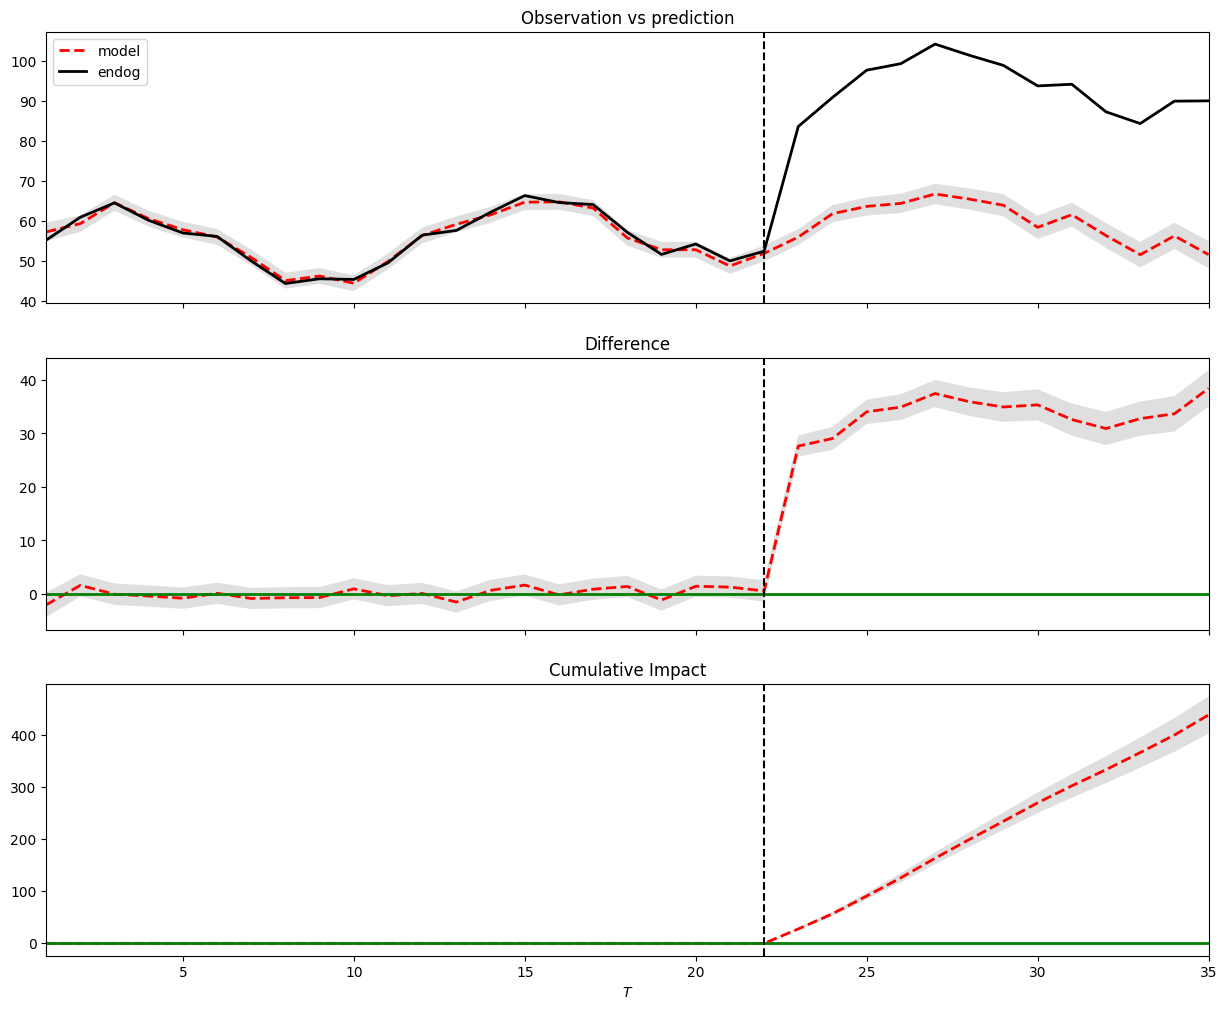

In [7]:
# Gera gráficos com os principais resultados do modelo:
# - Série observada vs contrafactual estimado
# - Diferença entre eles (efeito estimado)
# - Acumulado do efeito

impact.plot()

# 6 - Diagnóstico de Resíduos do Ajuste no Período Pré-Intervenção

#### Standardized residual for y

* O que mostra: Diferença entre os valores observados e os estimados pelo modelo durante o período pré-intervenção.

* Interpretação: Espera-se que os resíduos:

    * Oscilem em torno de zero;

    * Não tenham tendência sistemática;

    * Não apresentem padrões temporais (ex: não crescentes nem decrescentes).

* Problema se: Existe tendência clara, heterocedasticidade (mudança de variância ao longo do tempo), ou padrões sazonais nos resíduos.

#### Histogram plus estimated density

* O que mostra: Distribuição empírica dos resíduos.

* Interpretação: Deve se parecer com uma curva de sino (gaussiana), centrada em zero.

* Problema se: Assimetria, caudas longas, múltiplos picos — indicam falha no ajuste ou presença de outliers no período pré-intervenção.

#### Normal Q-Q

* O que mostra: Compara a distribuição dos resíduos com a distribuição normal teórica.

* Interpretação:

    * Se os resíduos forem aproximadamente normais, os pontos estarão alinhados com a linha diagonal.

    * Assim, o QQ-Plot testa normalidade dos resíduos, um pressuposto importante do modelo bayesiano estrutural.

* Problema se: Há curvatura ou cauda pesada visível, indicando distribuição não-normal.

#### Correlogram

* O que mostra: Correlações dos resíduos com seus próprios valores defasados.

* Interpretação: Se o modelo é bom, os resíduos devem ser não autocorrelacionados, ou seja, os valores de hoje não devem depender dos de ontem.

* Problema se: Barras da ACF ultrapassam os limites de confiança (linhas tracejadas), indicando autocorrelação. Isso sugere que o modelo deixou de capturar alguma estrutura temporal.

<Figure size 1200x800 with 0 Axes>

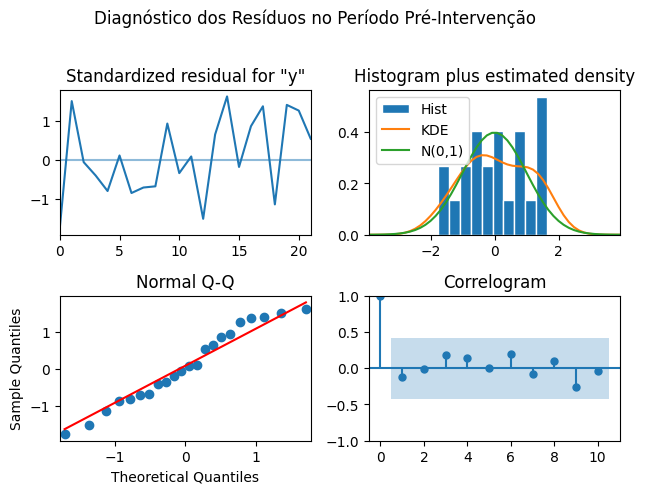

In [8]:
plt.figure(figsize=(12, 8))

# Plot com 4 gráficos de diagnóstico dos resíduos (pré-intervenção):

impact.results.results.plot_diagnostics()

plt.suptitle("Diagnóstico dos Resíduos no Período Pré-Intervenção", y=1.02)
plt.tight_layout()

# 7 - Interpretação Numérica e Report do impacto estimado

In [9]:
# Exibe o resumo dos resultados (impacto estimado, p-valores, intervalos de confiança)
print(impact.summary())

# Resumo estatístico estendido
print(impact.summary(output='report'))

                               Average      Cumulative
Actual                              93            1216
Predicted                           59             778
95% CI                        [57, 62]      [742, 813]
                                                      
Absolute Effect                     33             437
95% CI                        [36, 30]      [473, 402]
                                                      
Relative Effect                  56.3%           56.3%
95% CI                  [60.9%, 51.7%]  [60.9%, 51.7%]
                                                      
P-value                           0.0%                
Prob. of Causal Effect          100.0%                
None
During the post-intervention period, the response             variable had an average value of             approx. 93.
By contrast, in  the absence of an intervention, we would have expected an average response of 59. The 95% interval of
this counterfactual prediction is [57, 62]